In [1]:
# config
import sys
import numpy as np
import torch
assert torch.cuda.is_available()
%matplotlib inline
cuda_device = torch.device("cuda:0")
torch.cuda.set_device(cuda_device)
from config import config
setting = config(
    cuda_device, 
    model_save_name="",
    dataset_name="SHA"
)

In [2]:
from Dataset.DatasetConstructor import TrainDatasetConstructor,EvalDatasetConstructor
eval_dataset = EvalDatasetConstructor(
    setting.eval_num,
    setting.eval_img_path,
    setting.eval_gt_map_path,
    setting.eval_pers_path,
    mode=setting.mode,
    dataset_name=setting.dataset_name,
    device=setting.cuda_device)
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [4]:
# model construct
from net.RES_PERS_FPN.PERS_FPN import PERS_FPN
from eval.Estimator import Estimator
net = PERS_FPN(sigma=[1.25, 0.8, 0.2, 1], updates_signal=[True, True, True, True]).to(setting.cuda_device)
# net = FPN().to(setting.cuda_device)
net.load_state_dict(torch.load("/home/zzn/PycharmProjects/RESNET_FPN/StateDicts/RESPERS50FPN_A_7_19.pkl"))
optimizer = torch.optim.Adam(net.parameters(), setting.learning_rate)
criterion = torch.nn.MSELoss(reduction='sum').to(setting.cuda_device)
estimator = Estimator(setting, eval_loader, criterion=criterion)

In [6]:
print(list(list(list(list(net.children())[1].children())[1].children())[0].children())[0].params)
print(list(list(list(list(net.children())[1].children())[3].children())[0].children())[0].params)
print(list(list(list(list(net.children())[1].children())[5].children())[0].children())[0].params)
print(list(list(list(list(net.children())[1].children())[6].children())[0].children())[0].params)

Parameter containing:
tensor([0.7702, 0.7896, 0.1534, 1.1738], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.0631, 0.9983, 0.0311, 0.9946], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.1393, 0.9464, 0.0722, 0.9873], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.1025, 0.9038, 0.1041, 1.0313], device='cuda:0', requires_grad=True)


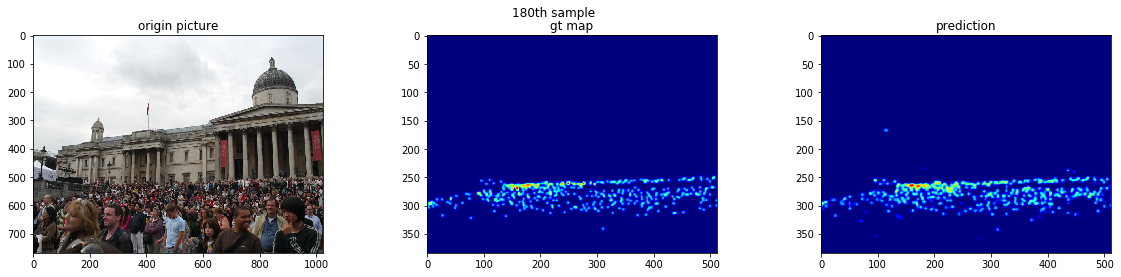

The gt counts of the above sample:398, and the pred counts:370.2675476074219
loss = 6.7598170313861345, eval_mae = 60.84909439086914, eval_rmse = 101.83856964111328, time cost eval = 30.226049184799194s


In [5]:
import warnings
import time
validate_MAE, validate_RMSE, validate_loss, time_cost = estimator.evaluate(net, True)
sys.stdout.write('loss = {}, eval_mae = {}, eval_rmse = {}, time cost eval = {}s\n'
                .format(validate_loss, validate_MAE, validate_RMSE, time_cost))
sys.stdout.flush()